# Analysis of patterns of sex-specific and sex-biased gene expression in *Populus balsamifera*

**Note**: the analyses that we report in this manuscript were performed with R version 3.3.0, and the Bioconductor packages for version 3.3.0. We have found that different versions of the Bioconductor packages identify different numbers of genes as differentially expressed (although the patterns are qualitatively the same). In the interest of reproducibility, the older release of Bioconductor packages DESeq2, limma, and edgeR can be installed with the following code in R:

In [ ]:
install.packages("BiocInstaller",repos="http://bioconductor.org/packages/3.3/bioc")

library("BiocInstaller")

biocLite("DESeq2")
biocLite("edgeR")
biocLite("limma")

## Load required packages

In [1]:
suppressMessages(library("DESeq2"))
suppressMessages(library("limma"))
suppressMessages(library("edgeR"))
suppressMessages(library("ggplot2"))
suppressMessages(library("VennDiagram"))
suppressMessages(library("cowplot"))
suppressMessages(library("viridis"))
suppressMessages(library("gplots"))

## Report version numbers of packages used for analysis

In [2]:
sessionInfo()

R version 3.3.0 (2016-05-03)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.4 LTS

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] gplots_3.0.1               viridis_0.5.1             
 [3] viridisLite_0.3.0          cowplot_0.9.2             
 [5] VennDiagram_1.6.20         futile.logger_1.4.3       
 [7] ggplot2_2.2.1              edgeR_3.14.0              
 [9] limma_3.28.21              DESeq2_1.12.4             
[11] SummarizedExperiment_1.2.3 Biobase_2.32.0            
[13] GenomicRanges_1

## Source functions for analyses

In [3]:
source("R/runDGE.R")
source("R/getSpecificGenes.R")

## Read in count data

Prior to analysis, raw reads were processed as follows:
* Adapter sequences were trimmed from the reads, and the read sequences were filtered for quality (Q=15) and minimum length (l=30) using fastq-mcf 
* Trimmed and filtered reads to the *Populus trichocarpa* reference genome version 3 using the program hisat2 v. 2.0.4 with the parameters --no-mixed, --no-discordant, --score-min L,0,-0.1, and --dta
* Gene expression was quantified using the program htseq-count version 0.6.0

The read counts are were then concatenated, and are available in Table S2, which is used for downstream analyses

In [4]:
TableS2 <- read.table("data/TableS2.txt", skip=1, header=T, stringsAsFactors=F,row.names=1)

group <- c("Mf","Mf","Mf","Mf","Mf",                  
           "Ff","Ff","Ff","Ff","Ff",                   
           "Ml","Ml","Ml","Ml","Ml",        
           "Fl","Fl","Fl","Fl","Fl")

lane <- c("L003","L003","L003","L003","L003",
          "L003","L003","L003","L004","L004",
          "L004","L004","L004","L004","L004",          
          "L005","L004","L005","L005","L005")

allCounts <- DGEList(TableS2)
allCounts$samples$group <- group
allCounts$samples$lane <- lane

### Remove metatags from count data

Drop the metatags for the reads that either didn't align to an annotated gene, or did so poorly.

Note: these features are included in Table S2 and should be removed before analysis.

In [5]:
allCounts <- allCounts[row.names(allCounts$counts)!= "__no_feature" &
                                     row.names(allCounts$counts)!= "__ambiguous" &
                                     row.names(allCounts$counts)!= "__too_low_aQual" & 
                                     row.names(allCounts$counts)!= "__not_aligned" & 
                                     row.names(allCounts$counts)!= "__alignment_not_unique",]

### Multidimensional scaling plot

Use an MDS plot to assess whether there are batch effects. We expect samples to cluster by sex and tissue, 
rather than by sequencing lane.

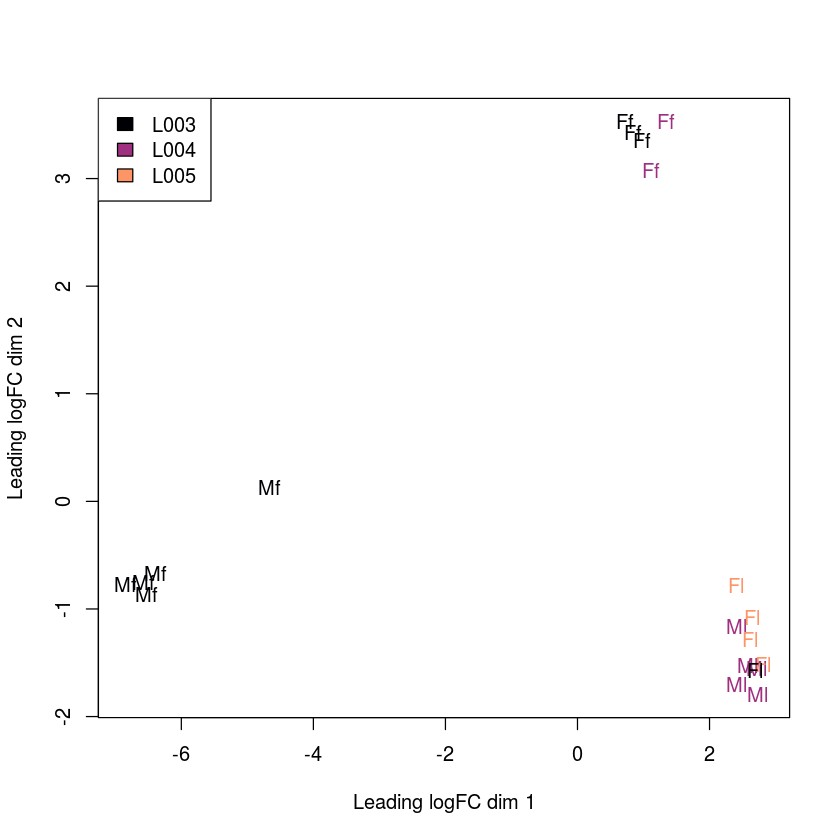

In [6]:
mdsCol = magma(10)[c(1,5,8)]

plotMDS(allCounts, labels=group, col=c(rep(mdsCol[1], 8), rep(mdsCol[2], 7), mdsCol[3], rep(mdsCol[3], 3)))
legend("topleft", fill=magma(10)[c(1,5,8)], legend=unique(allCounts$samples$lane))

## Sex-specific gene expression

**getSpecificGenes()** is a simple function that quantifies genes that are expressed and co-expressed in all combinations of sexes and tissues from this experiment. It returns a data frame of all the relevant genes, with variables that indicate whether a gene is expressed in each tissue (Y/N). For example, a gene expressed only in male flowers would have the following values:

In [8]:
specificGenes[1,]

gene,maleFlowers,femaleFlowers,maleLeaves,femaleLeaves
Potri.001G021900.v3.0,Y,N,N,N


NULL

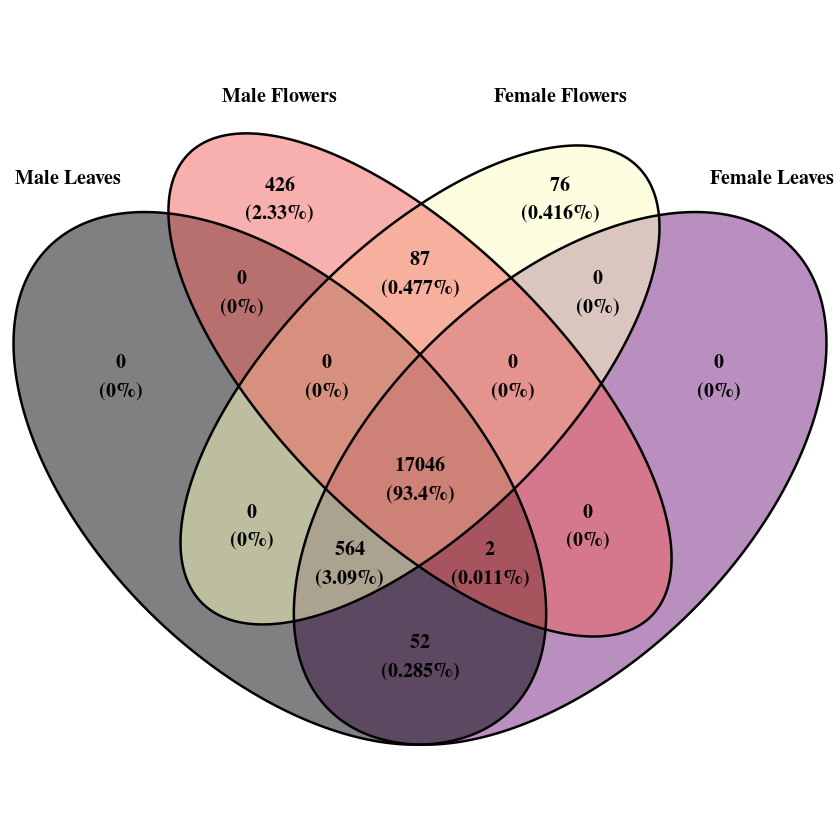

In [7]:
specificGenes <- getSpecificGenes(allCounts, incLib=5, excLib=5, thresh=0.1, type="CPM")


specificGeneCategories <- list(maleLeaves = specificGenes$gene[specificGenes$maleLeaves == "Y"],
                              femaleLeaves = specificGenes$gene[specificGenes$femaleLeaves == "Y"],
                              maleFlowers = specificGenes$gene[specificGenes$maleFlowers == "Y"],
                              femaleFlowers = specificGenes$gene[specificGenes$femaleFlowers == "Y"])

# Disable generation of log files for venn.diagram
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")

sexSpecificVenn <- venn.diagram(specificGeneCategories, filename=NULL, 
                              #fill=c("#ABABFF", "#FFABAB", "#FFFFAB", "#ABFFAB" )
                              fill=magma(4), 
                              #main="Sex- and tissue-specific expression", 
                              print.mode=c("raw", "percent"),
                              category.names=c("Male Leaves", "Female Leaves", "Male Flowers", "Female Flowers"),
                              fontface="bold",
                              cat.fontface="bold")
grid.draw(sexSpecificVenn)

## Sex-biased gene expression

### Filter lowly expressed genes

To limit false positives resulting from lowly expressed genes, genes with read counts below 0.1 counts per million (CPM) were removed prior to downstream analysis

In [9]:
flowerCountsRaw <- allCounts[,allCounts$samples$group=="Mf" | allCounts$samples$group=="Ff"]
flowerCountsRaw <- as.data.frame(flowerCountsRaw$counts)

flowerCounts <- flowerCountsRaw[rowSums(cpm(flowerCountsRaw)>0.1) >=5, ]

leafCountsRaw <- allCounts[,allCounts$samples$group=="Ml" | allCounts$samples$group=="Fl"]
leafCountsRaw <- as.data.frame(leafCountsRaw$counts)

leafCounts <- leafCountsRaw[rowSums(cpm(leafCountsRaw)>0.1) >=5, ]

### Run DGE function for flower and leaf counts separately

**runDGE()** is a function that takes a table of count data, the number of individuals in each comparision group, a significance threshold, and then estimates differential gene expression using **DESeq2**, **limma**, and **edgeR**. If *fullResults*=TRUE, the function returns the FDR and log<sub>2</sub>FC values for all genes. If *fullResults*=FALSE, then the function just returns the FDR and log<sub>2</sub>FC for genes that are below the FDR threshold across all analyses. 

The function also generates and MA plot to show the relationship between CPM and log<sub>2</sub>FC for all genes. The red dots are significantly differentially expressed with an FDR value below the threshold for all three analyses.

You have 11068 genes differentially expressed across all analyses 
You have 10750 genes differentially expressed across all analyses, with a 2-fold change 


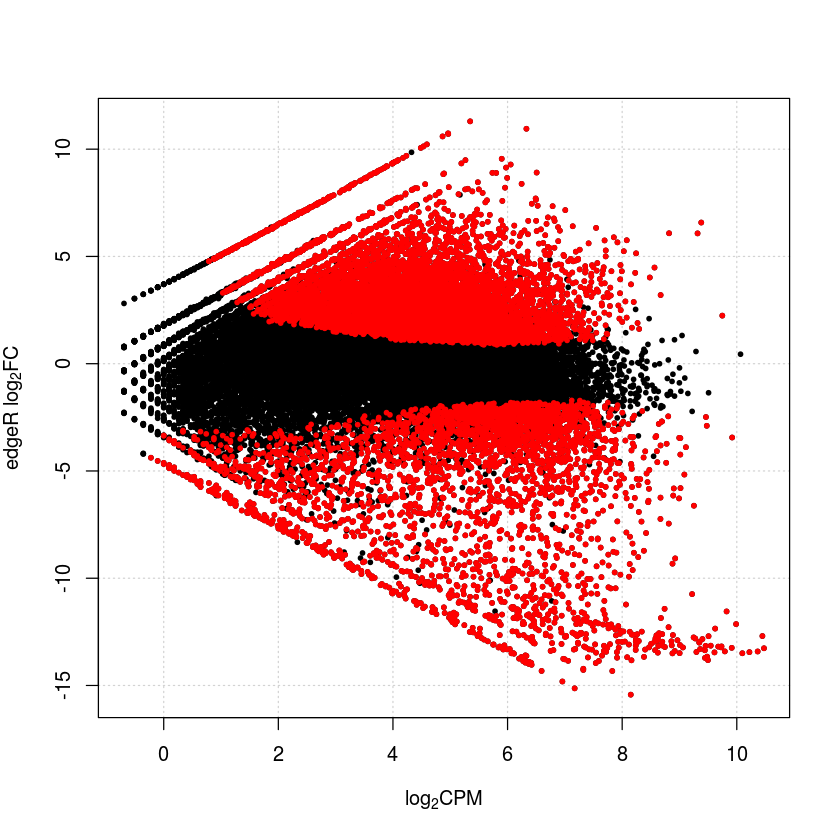

In [10]:
flowerAnalysis <- runDGE(flowerCounts,group1=5,group2=5,FDRthresh=0.01,fullResults=TRUE)

You have 1 genes differentially expressed across all analyses 
You have 1 genes differentially expressed across all analyses, with a 2-fold change 


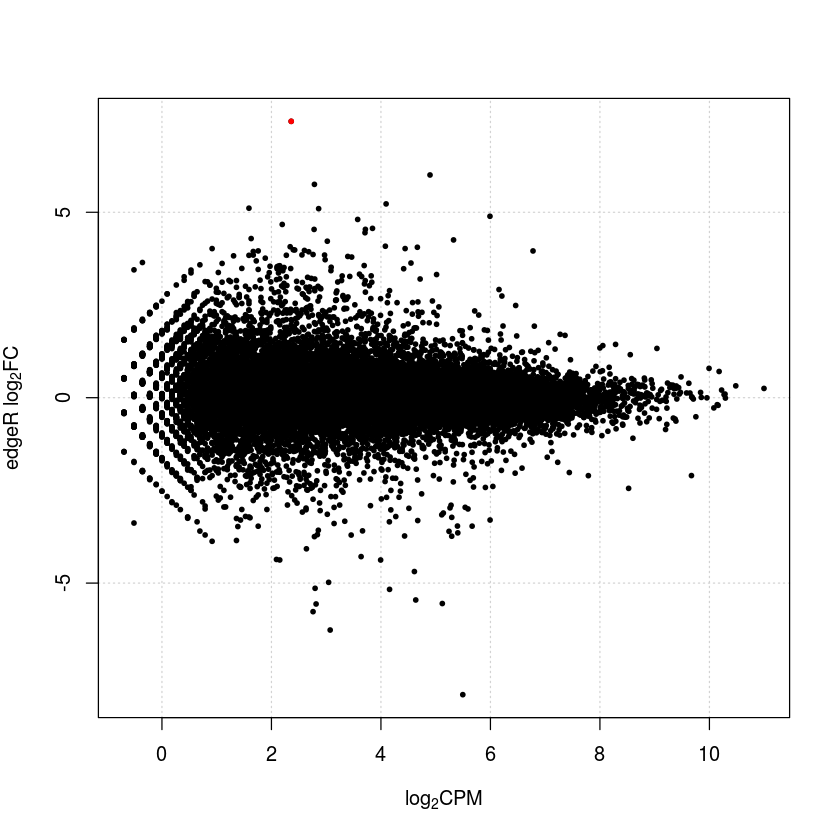

In [11]:
leafAnalysis <- runDGE(leafCounts,group1=5,group2=5,FDRthresh=0.01,fullResults=TRUE)

### Examine overlap in the significance estimates between DESeq2, edgeR, and limma

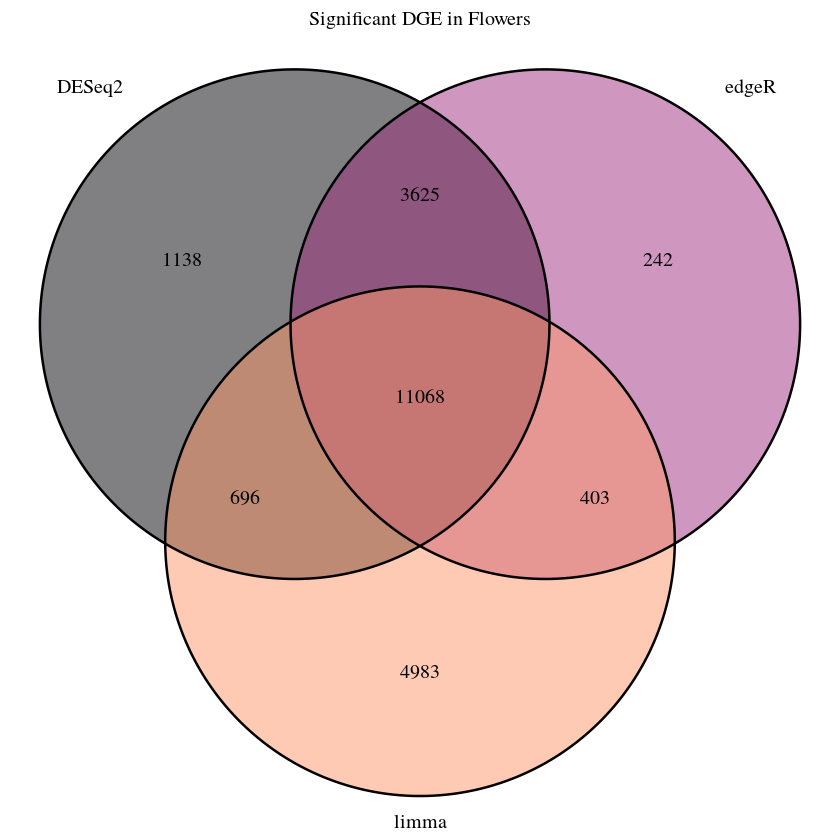

In [12]:
sigFlowerResults <- list(DESeq2 = flowerAnalysis$gene[flowerAnalysis$DESeq2_FDR < 0.01 & !is.na(flowerAnalysis$DESeq2_FDR)],
                         edgeR = flowerAnalysis$gene[flowerAnalysis$edgeR_FDR < 0.01 & !is.na(flowerAnalysis$edgeR_FDR)],
                         limma = flowerAnalysis$gene[flowerAnalysis$limma_FDR < 0.01 & !is.na(flowerAnalysis$limma_FDR)])
sigFlowerVenn <- venn.diagram(sigFlowerResults, filename=NULL, fill=magma(10)[c(1,5,8)], main="Significant DGE in Flowers", height = 3000, width = 3000)
grid.draw(sigFlowerVenn)

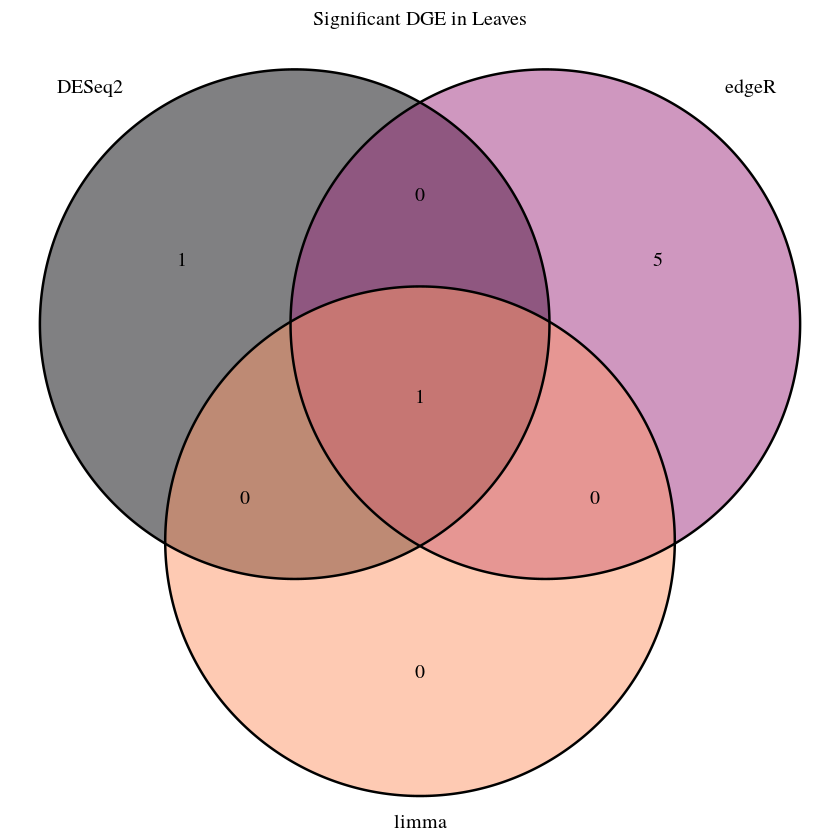

In [13]:
sigLeafResults <- list(DESeq2 = leafAnalysis$gene[leafAnalysis$DESeq2_FDR < 0.01 & !is.na(leafAnalysis$DESeq2_FDR)],
                         edgeR = leafAnalysis$gene[leafAnalysis$edgeR_FDR < 0.01 & !is.na(leafAnalysis$edgeR_FDR)],
                         limma = leafAnalysis$gene[leafAnalysis$limma_FDR < 0.01 & !is.na(leafAnalysis$limma_FDR)])
sigLeafVenn <- venn.diagram(sigLeafResults, filename=NULL, fill=magma(10)[c(1,5,8)],main="Significant DGE in Leaves",height = 3000, width = 3000)
grid.draw(sigLeafVenn)

### Plot heatmap of DGE in flowers

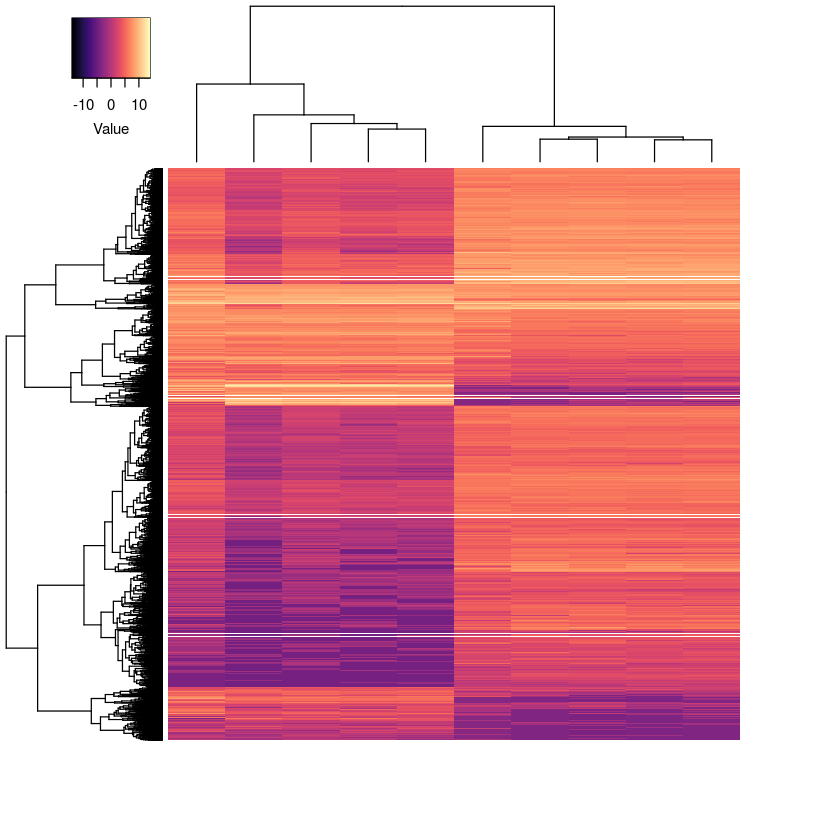

In [14]:
sigFlowerGenes <- flowerAnalysis$gene[flowerAnalysis$DESeq2_FDR < 0.01 & !is.na(flowerAnalysis$DESeq2_FDR) &
                                      flowerAnalysis$edgeR_FDR < 0.01 & !is.na(flowerAnalysis$edgeR_FDR) &
                                      flowerAnalysis$limma_FDR < 0.01 & !is.na(flowerAnalysis$limma_FDR)]

subAll <- allCounts[,allCounts$samples$group=="Mf" | allCounts$samples$group=="Ff"]

subAll <- subAll[row.names(subAll$counts) %in% sigFlowerGenes, ]

plotMap <- data.frame(subAll$counts)
plotMap$M1 <- cpm(plotMap[,1], log=T)
plotMap$M2 <- cpm(plotMap[,2], log=T)
plotMap$M3 <- cpm(plotMap[,3], log=T)
plotMap$M4 <- cpm(plotMap[,4], log=T)
plotMap$M5 <- cpm(plotMap[,5], log=T)
plotMap$F1 <- cpm(plotMap[,6], log=T)
plotMap$F2 <- cpm(plotMap[,7], log=T)
plotMap$F3 <- cpm(plotMap[,8], log=T)
plotMap$F4 <- cpm(plotMap[,9], log=T)
plotMap$F5 <- cpm(plotMap[,10], log=T)

plotMat <- as.matrix(cbind(plotMap[,c(11:20)]))

heatmap.2(plotMat, col=magma(256), density.info="none", trace="none", 
          labCol=NA, labRow=NA, key.title=NA, keysize = 1)